### TODO
- Add SE blocks to the multiply

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [33]:
# Set configs
batch_size = 16
batch_size_val = 16
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

In [34]:
# Load our data pipeline
loader = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val)

# Train set
img_ds = loader.get_image_ds().repeat()
masks_ds = loader.get_mask_ds().repeat()
label_ds = loader.get_binary_ds().repeat()
bbox_ds = loader.get_bboxes_ds().repeat()

# Validation set
img_ds_val = loader.get_image_ds(val=True).repeat()
masks_ds_val = loader.get_mask_ds(val=True).repeat()
label_ds_val = loader.get_binary_ds(val=True).repeat()
bbox_ds_val = loader.get_bboxes_ds(val=True).repeat()

Build our MTL

In [ ]:
### CLEARS OLD MODELS IN CACHE
tf.keras.backend.clear_session()

In [26]:
# Get encoder with attention unit
base_model_name = 'B0'
encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder_with_attention(trainable=True) # EfficientNet with attention

In [ ]:
encoder.summary()

In [ ]:
# Use our MTL framework to custom build a model
mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
mtl_builder.add_segmentation_head()
mtl_builder.add_binary_classification_head(base_model_name, trainable=True)
mtl_builder.add_bbox_classification_head(base_model_name, trainable=True)
model = mtl_builder.build_mtl_model()

In [28]:
model.trainable = True

In [ ]:
model.summary()

Train model

In [29]:
def generator_img():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        # Regularisation and shuffling
        X, Y1, Y2, Y3 = tools.get_randomised_data([X, Y1, Y2, Y3])
        X, Y1, Y3 = tools.data_augmentation(X, Y1, Y3) # Fix augmentation
        
        yield X, (Y1, Y2, Y3)

In [30]:
def generator_img_val():
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds_val.as_numpy_iterator()
    b = masks_ds_val.as_numpy_iterator()
    c = label_ds_val.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        yield X, (Y1, Y2, Y3)

In [38]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                    'bin_class_out' : tf.keras.losses.BinaryCrossentropy(),
                    'bbox_out' : tf.keras.losses.MeanAbsoluteError()},
              loss_weights=[1,1,1/100], # Scale MAE to BC range
              metrics=['accuracy'])

In [42]:
history = model.fit(generator_img(), validation_data=generator_img_val(), epochs=5, steps_per_epoch=num_train//batch_size, validation_steps=num_val//batch_size_val)

Epoch 1/5
69/69 [==============================] - 82s 1s/step - loss: 0.2353 - segnet_out_loss: 0.0883 - bin_class_out_loss: 5.5595e-05 - bbox_out_loss: 14.6860 - segnet_out_accuracy: 0.9656 - bin_class_out_accuracy: 1.0000 - bbox_out_accuracy: 0.8170 - val_loss: 0.5292 - val_segnet_out_loss: 0.1146 - val_bin_class_out_loss: 0.0093 - val_bbox_out_loss: 40.5288 - val_segnet_out_accuracy: 0.9580 - val_bin_class_out_accuracy: 0.9959 - val_bbox_out_accuracy: 0.5842
Epoch 2/5
69/69 [==============================] - 82s 1s/step - loss: 0.2292 - segnet_out_loss: 0.0869 - bin_class_out_loss: 6.9590e-05 - bbox_out_loss: 14.2286 - segnet_out_accuracy: 0.9662 - bin_class_out_accuracy: 1.0000 - bbox_out_accuracy: 0.8274 - val_loss: 0.5261 - val_segnet_out_loss: 0.1144 - val_bin_class_out_loss: 0.0084 - val_bbox_out_loss: 40.3358 - val_segnet_out_accuracy: 0.9579 - val_bin_class_out_accuracy: 0.9986 - val_bbox_out_accuracy: 0.5883
Epoch 3/5
69/69 [==============================] - 81s 1s/step - l

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(10)), history.history['segnet_out_accuracy'], 'r-', label='Segmentation - Training Accuracy')
ax.plot(list(range(10)), history.history['val_segnet_out_accuracy'], 'r--', label='Segmentation - Validation Accuracy')
ax.plot(list(range(10)), history.history['bin_class_out_accuracy'], 'c-', label='Classification - Training Accuracy')
ax.plot(list(range(10)), history.history['val_bin_class_out_accuracy'], 'c--', label='Classification - Validation Accuracy')
ax2 = ax.twinx()
ax.plot(list(range(10)), history.history['bbox_out_accuracy'], 'm-', label='Bounding Box - Training Accuracy')
ax.plot(list(range(10)), history.history['val_bbox_out_accuracy'], 'm--', label='Bounding Box - Validation Accuracy')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Segmentation/Classification Accuracy')
ax2.set_ylabel('Bounding Box Accuracy')

In [44]:
model.save('EffishingNetAtt_Eff')

INFO:tensorflow:Assets written to: EffishingNetAtt_Eff/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Test on test-set

In [ ]:
model = tf.keras.models.load_model('model_weights/EffishingNetAtt_Eff')

In [18]:
# Load test-set
img_ds_test = loader.get_image_ds(test_mode=True)
masks_ds_test = loader.get_mask_ds(test_mode=True)
label_ds_test = loader.get_binary_ds(test_mode=True)
bbox_ds_test = loader.get_bboxes_ds(test_mode=True)

In [43]:
# Predict on test-set
seg_pred, bin_pred, bbox_pred = model.predict(img_ds_test, batch_size=10)
seg_pred = tf.where(seg_pred >= 0, 1, 0) # Convert to {0,1} binary classes
bin_pred = np.round(bin_pred) # Round confidence score

bin_acc = np.sum(bin_pred == label_ds_test)/label_ds_test.shape[0]
seg_acc = np.sum(seg_pred == masks_ds_test)/(masks_ds_test.shape[0]*(img_height*img_width))
iou = np.mean(tools.calculate_iou(bbox_ds_test, bbox_pred))
print(f'Binary Acc: {round(bin_acc*100, 3)}%,   Seg Acc: {round(seg_acc*100, 3)}%,    BBox IOU: {round(iou*100, 3)}%')

Binary Acc: 98.916%,   Seg Acc: 95.843%,    BBox IOU: 73.169%


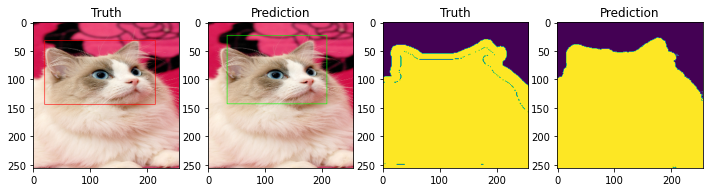

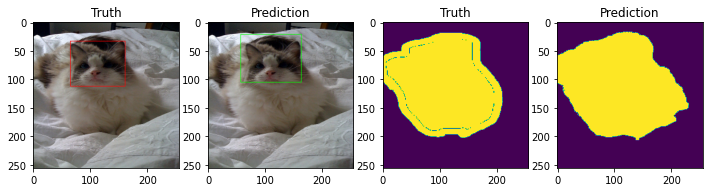

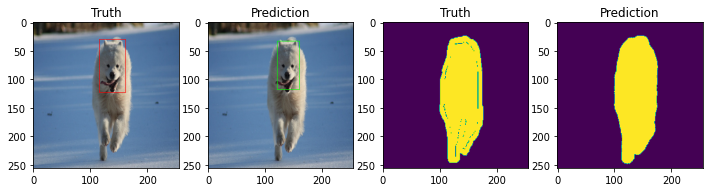

In [46]:
# Visualise predictions
idx = list(range(img_ds_test.shape[0]))
random.shuffle(idx)
for i in range(3):
    tools.show_seg_pred(img_ds_test[idx[i]], masks_ds_test[idx[i]], seg_pred[idx[i]][tf.newaxis, ...], bbox_ds_test[idx[i]], bbox_pred[idx[i]])